In [0]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data
import torchvision
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
import numpy as np

In [0]:
train_data = torchvision.datasets.MNIST(root = '/content/', transform=torchvision.transforms.ToTensor(),train=True, target_transform=None, download=True)
test_data = torchvision.datasets.MNIST(root = '/content/',transform=torchvision.transforms.ToTensor(), train=False, target_transform=None, download=True)

In [0]:
train_images = train_data.data.view(60000,-1)/255.
test_images = test_data.data.view(10000,-1)/255.

# 1. Comparing PCA and Autoencoders

**PCA**

In [142]:
pca = PCA(n_components = 30)
pca.fit(train_images)

PCA(copy=True, iterated_power='auto', n_components=30, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [0]:
train_transform = pca.transform(train_images)
test_transform = pca.transform(test_images)

In [0]:
train_reconstructed = pca.inverse_transform(train_transform)
test_reconstructed = pca.inverse_transform(test_transform)

In [0]:
train_images_recon = train_reconstructed.reshape(-1,28,28)
test_images_recon = test_reconstructed.reshape(-1,28,28)


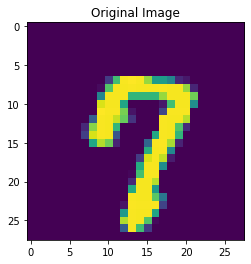

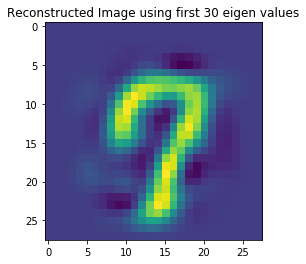

In [146]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28))
plt.title('Original Image')
plt.show()
plt.imshow(test_images_recon[rand_no])
plt.title('Reconstructed Image using first 30 eigen values')
plt.show()


**MSE for PCA reconstructed image and Original image**

In [147]:
print('MSE:',np.mean((test_reconstructed-test_images.numpy())*(test_reconstructed-test_images.numpy())))

MSE: 0.017687040359335434


**Autoencoders**

In [0]:
train_data, val_data = torch.utils.data.random_split(train_images, lengths= [50000,10000])

In [0]:
train_loader = torch.utils.data.DataLoader(train_data, batch_size = 64, shuffle = True)
val_loader = torch.utils.data.DataLoader(val_data, batch_size = 64, shuffle = True)
test_loader = torch.utils.data.DataLoader(test_images, batch_size = 64, shuffle = True)

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 512),
            nn.ReLU(True),
            nn.Linear(512, 256),
            nn.ReLU(True), nn.Linear(256, 128),nn.ReLU(True), nn.Linear(128, 30),nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(30, 128),
            nn.ReLU(True),
            nn.Linear(128, 256),
            nn.ReLU(True),
            nn.Linear(256, 784),nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [0]:
model = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model.parameters(), lr= 0.001)

In [152]:
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        output = model(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model(images)
            loss_train = criterion(outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model(images)
            loss_val = criterion(outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0302	 val_loss:0.0302
epoch [2/20], train_loss:0.0239	 val_loss:0.0240
epoch [3/20], train_loss:0.0215	 val_loss:0.0217
epoch [4/20], train_loss:0.0202	 val_loss:0.0204
epoch [5/20], train_loss:0.0182	 val_loss:0.0185
epoch [6/20], train_loss:0.0176	 val_loss:0.0178
epoch [7/20], train_loss:0.0170	 val_loss:0.0173
epoch [8/20], train_loss:0.0165	 val_loss:0.0169
epoch [9/20], train_loss:0.0158	 val_loss:0.0162
epoch [10/20], train_loss:0.0155	 val_loss:0.0159
epoch [11/20], train_loss:0.0153	 val_loss:0.0157
epoch [12/20], train_loss:0.0150	 val_loss:0.0154
epoch [13/20], train_loss:0.0151	 val_loss:0.0155
epoch [14/20], train_loss:0.0150	 val_loss:0.0155
epoch [15/20], train_loss:0.0147	 val_loss:0.0152
epoch [16/20], train_loss:0.0145	 val_loss:0.0150
epoch [17/20], train_loss:0.0143	 val_loss:0.0149
epoch [18/20], train_loss:0.0142	 val_loss:0.0147
epoch [19/20], train_loss:0.0142	 val_loss:0.0148
epoch [20/20], train_loss:0.0142	 val_loss:0.0148


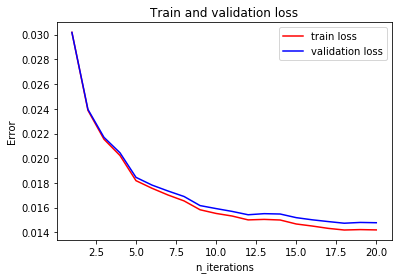

In [153]:
epoch = [i for i in range(1,len(run_train_loss)+1)]
plt.plot(epoch,run_train_loss,'-r')
plt.plot(epoch,run_val_loss,'-b')
plt.title('Train and validation loss')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('train loss','validation loss'))
plt.show()

In [154]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.01476149426500319


In [0]:
test_auto = model(test_images.type(torch.FloatTensor).cuda())

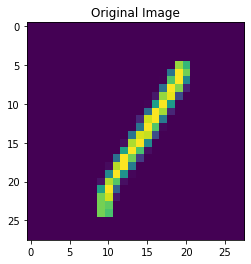

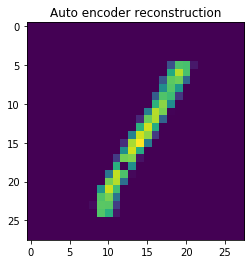

In [156]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28))
plt.title('Original Image')
plt.show()
plt.imshow(test_auto[rand_no].data.cpu().view(28,28))
plt.title('Auto encoder reconstruction')
plt.show()

Reconstruction is better in case of Autoencoder. MSE after reconstruction was 0.0177 in case of PCA while it is 0.0146 in case of Autoencoder

# 2. Experimenting with hidden units of varying sizes

**Hidden Units: 64**

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(64, 784),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [0]:
model1 = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model1.parameters(), lr= 0.001)

In [159]:
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        output = model1(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model1(images)
            loss_train = criterion(outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model1(images)
            loss_val = criterion(outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0159	 val_loss:0.0160
epoch [2/20], train_loss:0.0140	 val_loss:0.0141
epoch [3/20], train_loss:0.0133	 val_loss:0.0133
epoch [4/20], train_loss:0.0130	 val_loss:0.0131
epoch [5/20], train_loss:0.0129	 val_loss:0.0129
epoch [6/20], train_loss:0.0128	 val_loss:0.0129
epoch [7/20], train_loss:0.0126	 val_loss:0.0127
epoch [8/20], train_loss:0.0126	 val_loss:0.0127
epoch [9/20], train_loss:0.0126	 val_loss:0.0127
epoch [10/20], train_loss:0.0126	 val_loss:0.0127
epoch [11/20], train_loss:0.0125	 val_loss:0.0126
epoch [12/20], train_loss:0.0125	 val_loss:0.0126
epoch [13/20], train_loss:0.0126	 val_loss:0.0127
epoch [14/20], train_loss:0.0125	 val_loss:0.0126
epoch [15/20], train_loss:0.0125	 val_loss:0.0126
epoch [16/20], train_loss:0.0125	 val_loss:0.0126
epoch [17/20], train_loss:0.0125	 val_loss:0.0126
epoch [18/20], train_loss:0.0125	 val_loss:0.0126
epoch [19/20], train_loss:0.0125	 val_loss:0.0126
epoch [20/20], train_loss:0.0125	 val_loss:0.0126


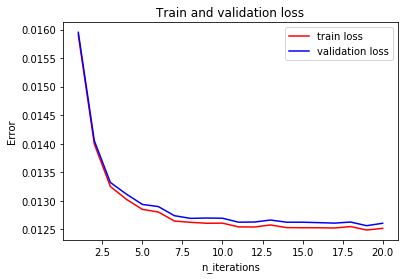

In [160]:
epoch = [i for i in range(1,len(run_train_loss)+1)]
plt.plot(epoch,run_train_loss,'-r')
plt.plot(epoch,run_val_loss,'-b')
plt.title('Train and validation loss')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('train loss','validation loss'))
plt.show()

In [161]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model1(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.012463007733273279


In [0]:
test_auto = model1(test_images.type(torch.FloatTensor).cuda())

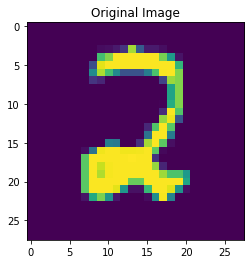

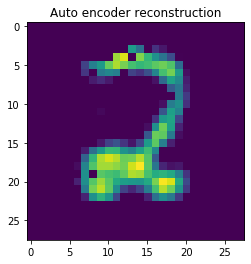

In [163]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28))
plt.title('Original Image')
plt.show()
plt.imshow(test_auto[rand_no].data.cpu().view(28,28))
plt.title('Auto encoder reconstruction')
plt.show()

**Hidden Units:128**

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(128, 784),
            nn.ReLU(True))

    def forward(self, x):
        enc = self.encoder(x)
        x = self.decoder(enc)
        return enc,x


In [0]:
model2 = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model2.parameters(), lr= 0.001)

In [166]:
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        _,output = model2(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            _,outputs = model2(images)
            loss_train = criterion(outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            _,outputs = model2(images)
            loss_val = criterion(outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0111	 val_loss:0.0112
epoch [2/20], train_loss:0.0096	 val_loss:0.0096
epoch [3/20], train_loss:0.0091	 val_loss:0.0092
epoch [4/20], train_loss:0.0090	 val_loss:0.0091
epoch [5/20], train_loss:0.0089	 val_loss:0.0090
epoch [6/20], train_loss:0.0088	 val_loss:0.0089
epoch [7/20], train_loss:0.0087	 val_loss:0.0088
epoch [8/20], train_loss:0.0087	 val_loss:0.0088
epoch [9/20], train_loss:0.0087	 val_loss:0.0088
epoch [10/20], train_loss:0.0086	 val_loss:0.0087
epoch [11/20], train_loss:0.0086	 val_loss:0.0087
epoch [12/20], train_loss:0.0086	 val_loss:0.0087
epoch [13/20], train_loss:0.0086	 val_loss:0.0087
epoch [14/20], train_loss:0.0085	 val_loss:0.0086
epoch [15/20], train_loss:0.0086	 val_loss:0.0086
epoch [16/20], train_loss:0.0085	 val_loss:0.0086
epoch [17/20], train_loss:0.0085	 val_loss:0.0086
epoch [18/20], train_loss:0.0085	 val_loss:0.0086
epoch [19/20], train_loss:0.0085	 val_loss:0.0086
epoch [20/20], train_loss:0.0085	 val_loss:0.0086


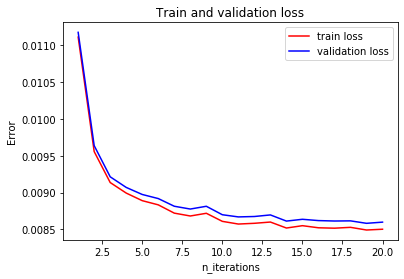

In [167]:
epoch = [i for i in range(1,len(run_train_loss)+1)]
plt.plot(epoch,run_train_loss,'-r')
plt.plot(epoch,run_val_loss,'-b')
plt.title('Train and validation loss')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('train loss','validation loss'))
plt.show()

In [168]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            _,outputs = model2(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.008505119663325084


In [0]:
_,test_auto = model2(test_images.type(torch.FloatTensor).cuda())

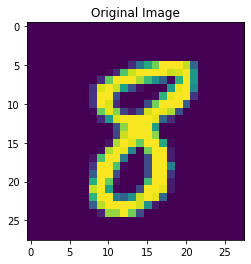

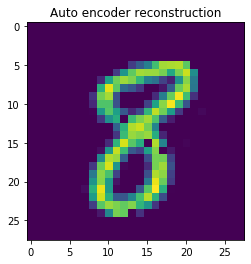

In [170]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28))
plt.title('Original Image')
plt.show()
plt.imshow(test_auto[rand_no].data.cpu().view(28,28))
plt.title('Auto encoder reconstruction')
plt.show()

**Hidden Units:256**



In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 256),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(256, 784),
            nn.ReLU(True))

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [0]:
model3 = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model3.parameters(), lr= 0.001)

In [0]:
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        output = model3(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model3(images)
            loss_train = criterion(outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model3(images)
            loss_val = criterion(outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0089	 val_loss:0.0090
epoch [2/20], train_loss:0.0078	 val_loss:0.0079
epoch [3/20], train_loss:0.0074	 val_loss:0.0075
epoch [4/20], train_loss:0.0072	 val_loss:0.0073
epoch [5/20], train_loss:0.0071	 val_loss:0.0072
epoch [6/20], train_loss:0.0070	 val_loss:0.0071
epoch [7/20], train_loss:0.0070	 val_loss:0.0071
epoch [8/20], train_loss:0.0070	 val_loss:0.0071
epoch [9/20], train_loss:0.0070	 val_loss:0.0071
epoch [10/20], train_loss:0.0070	 val_loss:0.0070
epoch [11/20], train_loss:0.0069	 val_loss:0.0070
epoch [12/20], train_loss:0.0069	 val_loss:0.0070
epoch [13/20], train_loss:0.0069	 val_loss:0.0070
epoch [14/20], train_loss:0.0069	 val_loss:0.0070
epoch [15/20], train_loss:0.0069	 val_loss:0.0070
epoch [16/20], train_loss:0.0069	 val_loss:0.0070
epoch [17/20], train_loss:0.0069	 val_loss:0.0070
epoch [18/20], train_loss:0.0068	 val_loss:0.0069
epoch [19/20], train_loss:0.0069	 val_loss:0.0069
epoch [20/20], train_loss:0.0069	 val_loss:0.0070


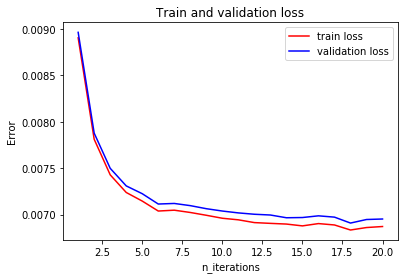

In [0]:
epoch = [i for i in range(1,len(run_train_loss)+1)]
plt.plot(epoch,run_train_loss,'-r')
plt.plot(epoch,run_val_loss,'-b')
plt.title('Train and validation loss')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('train loss','validation loss'))
plt.show()

In [0]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model3(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.006792765552664448


In [0]:
test_auto = model3(test_images.type(torch.FloatTensor).cuda())

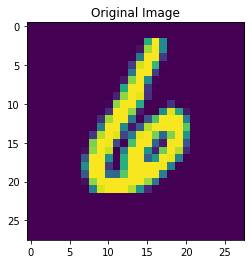

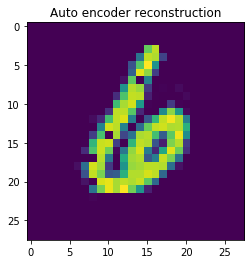

In [0]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28))
plt.title('Original Image')
plt.show()
plt.imshow(test_auto[rand_no].data.cpu().view(28,28))
plt.title('Auto encoder reconstruction')
plt.show()

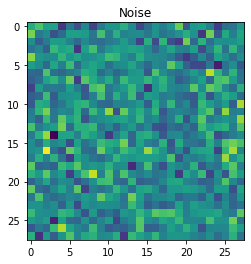

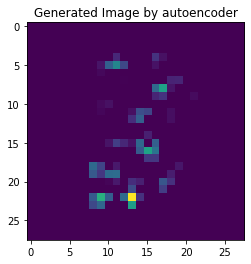

In [272]:
random_noise = torch.Tensor(np.random.normal(0,0.1,(28,28)))
plt.imshow(random_noise)
plt.title('Noise')
plt.show()
plt.imshow(model2(random_noise.view(784).cuda())[1].view(28,28).cpu().data)
plt.title('Generated Image by autoencoder')
plt.show()

Reconstruction Accuracy increases as we increase the hidden unit dimension from 64  to 256. However this will saturate later as the correct manifold dimension is learned.
When we pass random noise we get image which look almost like a digit in few cases.

# Sparse Autoencoders

In [0]:
class sparse_autoencoder(nn.Module):
    def __init__(self):
        super(sparse_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(128, 784),
            nn.ReLU(True))

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded


In [0]:
model4 = sparse_autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model4.parameters(), lr= 0.001)

In [173]:
beta = 0.05
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        enc_output,dec_output = model4(img)
        loss = criterion(dec_output, img)
        sparse_loss = beta*torch.mean(abs(enc_output))
        total_loss = loss + sparse_loss
        # ===================backward====================
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            enc_outputs,dec_outputs = model4(images)
            loss_train = criterion(dec_outputs, images)
            sparse_loss_train = beta*torch.mean(abs(enc_outputs))
            total_loss_train = loss_train+sparse_loss
            train_loss += total_loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            enc_outputs,dec_outputs = model4(images)
            loss_val = criterion(dec_outputs, images)
            sparse_loss_val = beta*torch.mean(abs(enc_outputs))
            total_loss_val = loss_val+sparse_loss_val
            val_loss += total_loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0201	 val_loss:0.0206
epoch [2/20], train_loss:0.0172	 val_loss:0.0175
epoch [3/20], train_loss:0.0158	 val_loss:0.0161
epoch [4/20], train_loss:0.0146	 val_loss:0.0152
epoch [5/20], train_loss:0.0146	 val_loss:0.0145
epoch [6/20], train_loss:0.0142	 val_loss:0.0140
epoch [7/20], train_loss:0.0133	 val_loss:0.0136
epoch [8/20], train_loss:0.0133	 val_loss:0.0133
epoch [9/20], train_loss:0.0130	 val_loss:0.0135
epoch [10/20], train_loss:0.0130	 val_loss:0.0131
epoch [11/20], train_loss:0.0129	 val_loss:0.0129
epoch [12/20], train_loss:0.0126	 val_loss:0.0127
epoch [13/20], train_loss:0.0127	 val_loss:0.0127
epoch [14/20], train_loss:0.0129	 val_loss:0.0126
epoch [15/20], train_loss:0.0125	 val_loss:0.0129
epoch [16/20], train_loss:0.0126	 val_loss:0.0125
epoch [17/20], train_loss:0.0127	 val_loss:0.0124
epoch [18/20], train_loss:0.0122	 val_loss:0.0123
epoch [19/20], train_loss:0.0123	 val_loss:0.0123
epoch [20/20], train_loss:0.0119	 val_loss:0.0121


**Visualizing the weights/filters of Sparse Autoencoder and Normal encoder**

In [0]:
params = []
for i in model4.parameters():
  params.append(i)

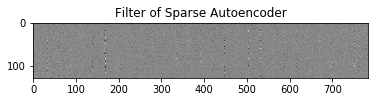

In [175]:
plt.imshow(params[0].cpu().data,'gray')
plt.title('Filter of Sparse Autoencoder')
plt.show()

In [0]:
params = []
for i in model2.parameters():
  params.append(i)

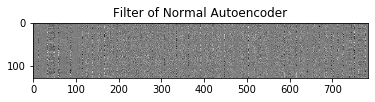

In [178]:
plt.imshow(params[0].cpu().data,'gray')
plt.title('Filter of Normal Autoencoder')
plt.show()

From above plots, we can see that filters of Sparse Autoencoders are more sparse they have more black pixels as compared to Normal Autoencoders 

**Visualizing Hidden layer encoding for Auto encoders and Sparse Encoders**

Text(0.5, 1.0, 'Sparse Autoencoder Hidden unit(128) plotted as 8*16 matrix')

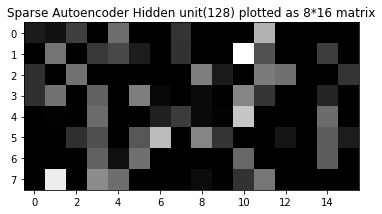

In [179]:
rand_no = np.random.randint(0,10000)
plt.imshow(model4(test_images[rand_no].type(torch.FloatTensor).cuda())[0].cpu().data.view(8,16),'gray')
plt.title('Sparse Autoencoder Hidden unit(128) plotted as 8*16 matrix')

**Average Hidden activation in Sparse Autoencoder**

In [191]:
print(torch.mean(model4(test_images[rand_no].type(torch.FloatTensor).cuda())[0].cpu().data))

tensor(0.0458)


Text(0.5, 1.0, 'Normal Autoencoder Hidden unit(128) plotted as 8*16 matrix')

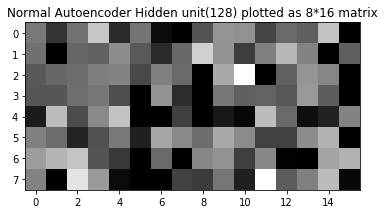

In [192]:
plt.imshow(model2(test_images[rand_no].type(torch.FloatTensor).cuda())[0].cpu().data.view(8,16),'gray')
plt.title('Normal Autoencoder Hidden unit(128) plotted as 8*16 matrix')

**Average Hidden activation in Normal Autoencoder**

In [194]:
print(torch.mean(model2(test_images[rand_no].type(torch.FloatTensor).cuda())[0].cpu().data))

tensor(0.5009)


Comparing the Hidden units of Normal Autoencoders with Sparse Autoencoders, We observe that there are lot of black pixels(Zero Values) in Sparse Autoencoder indicating Sparsity in it. Also, comparing the avg hidden activation, we can see that it is less in sparse autoencoder(0.0458) than normal autoencoder(0.5009).

# 4. Denoising Autoencoders

**Sigma = 0.3**

In [0]:
class denoising_autoencoder(nn.Module):
    def __init__(self):
        super(denoising_autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(128, 784),
            nn.ReLU(True))

    def forward(self, x):
        enc = self.encoder(x)
        x = self.decoder(enc)
        return enc,x


In [0]:
model5 = denoising_autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model5.parameters(), lr= 0.001)

In [0]:
beta = 0.05
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        img1 = img  + torch.Tensor(np.random.normal(0,0.3,(img.size(0),784))).cuda()
        # ===================forward=====================
        img1 = img1.type(torch.FloatTensor).cuda()
        enc_output,dec_output = model5(img1)
        loss = criterion(dec_output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.3,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model5(images1)
            loss_train = criterion(dec_outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.3,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model5(images1)
            loss_val = criterion(dec_outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0158	 val_loss:0.0158
epoch [2/20], train_loss:0.0149	 val_loss:0.0149
epoch [3/20], train_loss:0.0145	 val_loss:0.0146
epoch [4/20], train_loss:0.0144	 val_loss:0.0145
epoch [5/20], train_loss:0.0142	 val_loss:0.0143
epoch [6/20], train_loss:0.0141	 val_loss:0.0142
epoch [7/20], train_loss:0.0141	 val_loss:0.0142
epoch [8/20], train_loss:0.0140	 val_loss:0.0142
epoch [9/20], train_loss:0.0140	 val_loss:0.0141
epoch [10/20], train_loss:0.0139	 val_loss:0.0140
epoch [11/20], train_loss:0.0139	 val_loss:0.0140
epoch [12/20], train_loss:0.0139	 val_loss:0.0140
epoch [13/20], train_loss:0.0140	 val_loss:0.0141
epoch [14/20], train_loss:0.0139	 val_loss:0.0140
epoch [15/20], train_loss:0.0139	 val_loss:0.0140
epoch [16/20], train_loss:0.0138	 val_loss:0.0139
epoch [17/20], train_loss:0.0138	 val_loss:0.0139
epoch [18/20], train_loss:0.0138	 val_loss:0.0139
epoch [19/20], train_loss:0.0138	 val_loss:0.0139
epoch [20/20], train_loss:0.0138	 val_loss:0.0139


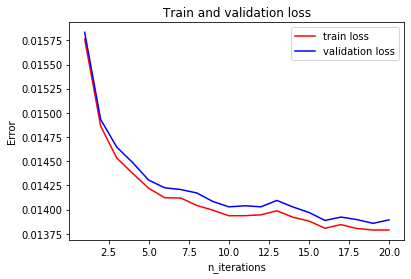

In [0]:
epoch = [i for i in range(1,len(run_train_loss)+1)]
plt.plot(epoch,run_train_loss,'-r')
plt.plot(epoch,run_val_loss,'-b')
plt.title('Train and validation loss')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('train loss','validation loss'))
plt.show()

In [0]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            _,outputs = model5(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.009406479582736257


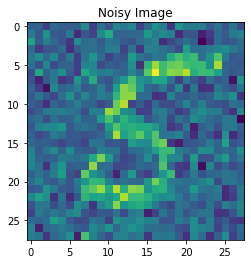

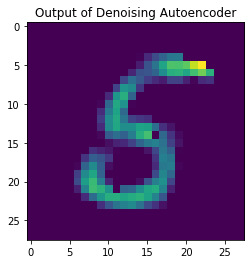

In [0]:
rand_no = np.random.randint(0,10000)
plt.imshow((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.3,(784)))).view(28,28))
plt.title('Noisy Image')
plt.show()
plt.imshow(model5((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.3,(784)))).cuda())[1].cpu().data.view(28,28))
plt.title('Output of Denoising Autoencoder')
plt.show()

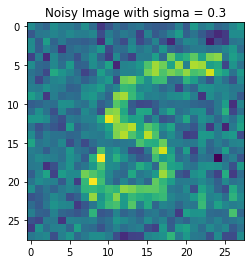

In [0]:

noisy_image = test_images[rand_no] + torch.Tensor(np.random.normal(0,0.3,(784)))
plt.imshow(noisy_image.view(28,28))
plt.title('Noisy Image with sigma = 0.3')
plt.show()

Text(0.5, 1.0, 'Denoised Image')

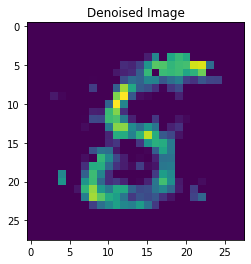

In [0]:
denoised_image = model2(noisy_image.cuda())[1]
plt.imshow(denoised_image.data.cpu().view(28,28))
plt.title('Denoised Image')

**sigma:0.5**

In [0]:
model6 = denoising_autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model6.parameters(), lr= 0.001)

In [277]:
beta = 0.05
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        img1 = img  + torch.Tensor(np.random.normal(0,0.5,(img.size(0),784))).cuda()
        # ===================forward=====================
        img1 = img1.type(torch.FloatTensor).cuda()
        enc_output,dec_output = model6(img1)
        loss = criterion(dec_output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.5,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model6(images1)
            loss_train = criterion(dec_outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.5,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model6(images1)
            loss_val = criterion(dec_outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0219	 val_loss:0.0219
epoch [2/20], train_loss:0.0208	 val_loss:0.0208
epoch [3/20], train_loss:0.0201	 val_loss:0.0201
epoch [4/20], train_loss:0.0198	 val_loss:0.0198
epoch [5/20], train_loss:0.0194	 val_loss:0.0195
epoch [6/20], train_loss:0.0192	 val_loss:0.0193
epoch [7/20], train_loss:0.0192	 val_loss:0.0192
epoch [8/20], train_loss:0.0191	 val_loss:0.0191
epoch [9/20], train_loss:0.0189	 val_loss:0.0189
epoch [10/20], train_loss:0.0189	 val_loss:0.0189
epoch [11/20], train_loss:0.0188	 val_loss:0.0188
epoch [12/20], train_loss:0.0186	 val_loss:0.0187
epoch [13/20], train_loss:0.0185	 val_loss:0.0186
epoch [14/20], train_loss:0.0185	 val_loss:0.0186
epoch [15/20], train_loss:0.0186	 val_loss:0.0187
epoch [16/20], train_loss:0.0186	 val_loss:0.0186
epoch [17/20], train_loss:0.0185	 val_loss:0.0186
epoch [18/20], train_loss:0.0184	 val_loss:0.0185
epoch [19/20], train_loss:0.0184	 val_loss:0.0184
epoch [20/20], train_loss:0.0184	 val_loss:0.0184


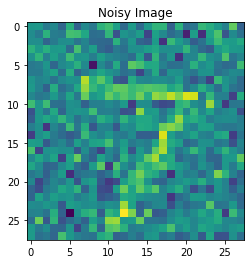

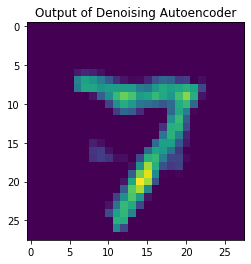

In [279]:
rand_no = np.random.randint(0,10000)
plt.imshow((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.5,(784)))).view(28,28))
plt.title('Noisy Image')
plt.show()
plt.imshow(model6((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.5,(784)))).cuda())[1].cpu().data.view(28,28))
plt.title('Output of Denoising Autoencoder')
plt.show()

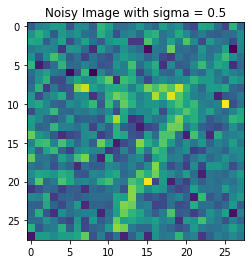

In [280]:

noisy_image = test_images[rand_no] + torch.Tensor(np.random.normal(0,0.5,(784)))
plt.imshow(noisy_image.view(28,28))
plt.title('Noisy Image with sigma = 0.5')
plt.show()

Text(0.5, 1.0, 'Denoised Image with standard autoencoder')

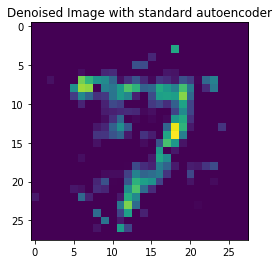

In [282]:
denoised_image = model2(noisy_image.cuda())[1]
plt.imshow(denoised_image.data.cpu().view(28,28))
plt.title('Denoised Image with standard autoencoder')

**Sigma:0.8**

In [0]:
model7 = denoising_autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model7.parameters(), lr= 0.001)

In [0]:
beta = 0.05
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        img1 = img  + torch.Tensor(np.random.normal(0,0.8,(img.size(0),784))).cuda()
        # ===================forward=====================
        img1 = img1.type(torch.FloatTensor).cuda()
        enc_output,dec_output = model7(img1)
        loss = criterion(dec_output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.8,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model7(images1)
            loss_train = criterion(dec_outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.8,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model7(images1)
            loss_val = criterion(dec_outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0286	 val_loss:0.0286
epoch [2/20], train_loss:0.0269	 val_loss:0.0269
epoch [3/20], train_loss:0.0263	 val_loss:0.0264
epoch [4/20], train_loss:0.0260	 val_loss:0.0261
epoch [5/20], train_loss:0.0258	 val_loss:0.0259
epoch [6/20], train_loss:0.0256	 val_loss:0.0258
epoch [7/20], train_loss:0.0255	 val_loss:0.0257
epoch [8/20], train_loss:0.0254	 val_loss:0.0255
epoch [9/20], train_loss:0.0253	 val_loss:0.0254
epoch [10/20], train_loss:0.0253	 val_loss:0.0252
epoch [11/20], train_loss:0.0253	 val_loss:0.0254
epoch [12/20], train_loss:0.0251	 val_loss:0.0252
epoch [13/20], train_loss:0.0251	 val_loss:0.0252
epoch [14/20], train_loss:0.0252	 val_loss:0.0252
epoch [15/20], train_loss:0.0252	 val_loss:0.0252
epoch [16/20], train_loss:0.0252	 val_loss:0.0252
epoch [17/20], train_loss:0.0250	 val_loss:0.0250
epoch [18/20], train_loss:0.0251	 val_loss:0.0251
epoch [19/20], train_loss:0.0251	 val_loss:0.0252
epoch [20/20], train_loss:0.0249	 val_loss:0.0250


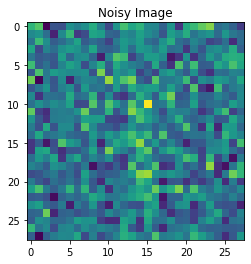

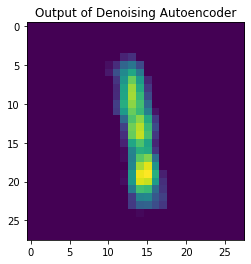

In [0]:
rand_no = np.random.randint(0,10000)
plt.imshow((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.8,(784)))).view(28,28))
plt.title('Noisy Image')
plt.show()
plt.imshow(model7((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.8,(784)))).cuda())[1].cpu().data.view(28,28))
plt.title('Output of Denoising Autoencoder')
plt.show()

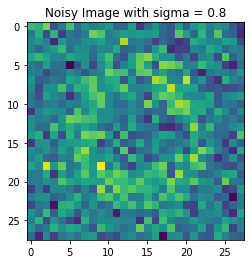

In [0]:
rand_no = np.random.randint(0,10000)
noisy_image = test_images[rand_no] + torch.Tensor(np.random.normal(0,0.8,(784)))
plt.imshow(noisy_image.view(28,28))
plt.title('Noisy Image with sigma = 0.8')
plt.show()

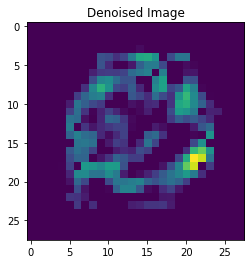

In [0]:
denoised_image = model2(noisy_image.cuda())[1]
plt.imshow(denoised_image.data.cpu().view(28,28))
plt.title('Denoised Image')
plt.show()

**Sigma:0.9**

In [0]:
model8 = denoising_autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model8.parameters(), lr= 0.001)

In [0]:
beta = 0.05
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img).cuda()
        img1 = img  + torch.Tensor(np.random.normal(0,0.9,(img.size(0),784))).cuda()
        # ===================forward=====================
        img1 = img1.type(torch.FloatTensor).cuda()
        enc_output,dec_output = model8(img1)
        loss = criterion(dec_output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.9,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model8(images1)
            loss_train = criterion(dec_outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            images1 = images + torch.Tensor(np.random.normal(0,0.9,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model8(images1)
            loss_val = criterion(dec_outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0310	 val_loss:0.0312
epoch [2/20], train_loss:0.0293	 val_loss:0.0293
epoch [3/20], train_loss:0.0286	 val_loss:0.0286
epoch [4/20], train_loss:0.0285	 val_loss:0.0285
epoch [5/20], train_loss:0.0283	 val_loss:0.0283
epoch [6/20], train_loss:0.0282	 val_loss:0.0282
epoch [7/20], train_loss:0.0281	 val_loss:0.0282
epoch [8/20], train_loss:0.0280	 val_loss:0.0280
epoch [9/20], train_loss:0.0279	 val_loss:0.0280
epoch [10/20], train_loss:0.0279	 val_loss:0.0279
epoch [11/20], train_loss:0.0277	 val_loss:0.0278
epoch [12/20], train_loss:0.0279	 val_loss:0.0278
epoch [13/20], train_loss:0.0277	 val_loss:0.0277
epoch [14/20], train_loss:0.0278	 val_loss:0.0278
epoch [15/20], train_loss:0.0277	 val_loss:0.0278
epoch [16/20], train_loss:0.0277	 val_loss:0.0277
epoch [17/20], train_loss:0.0278	 val_loss:0.0277
epoch [18/20], train_loss:0.0276	 val_loss:0.0277
epoch [19/20], train_loss:0.0277	 val_loss:0.0277
epoch [20/20], train_loss:0.0277	 val_loss:0.0277


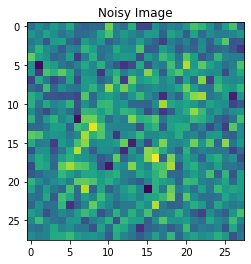

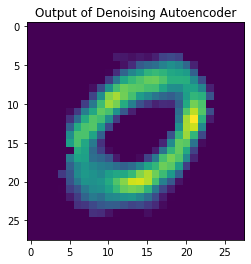

In [0]:
rand_no = np.random.randint(0,10000)
plt.imshow((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.9,(784)))).view(28,28))
plt.title('Noisy Image')
plt.show()
plt.imshow(model8((test_images[rand_no]+torch.Tensor(np.random.normal(0,0.9,(784)))).cuda())[1].cpu().data.view(28,28))
plt.title('Output of Denoising Autoencoder')
plt.show()

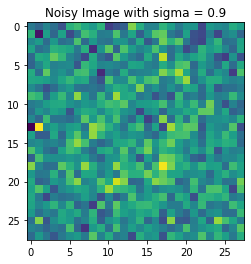

In [0]:

noisy_image = test_images[rand_no] + torch.Tensor(np.random.normal(0,0.9,(784)))
plt.imshow(noisy_image.view(28,28))
plt.title('Noisy Image with sigma = 0.9')
plt.show()

Text(0.5, 1.0, 'Denoised Image')

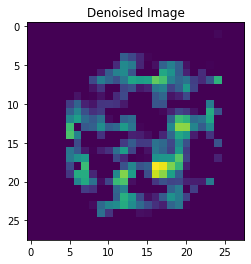

In [0]:
denoised_image = model2(noisy_image.cuda())[1]
plt.imshow(denoised_image.data.cpu().view(28,28))
plt.title('Denoised Image')

When you pass images corrupted with noise to the previously trained Standard Autoencoders, it could denoise it to some extent. But as we increase noise level the performance decrease.
When we build denoising encoder it does a better job than standard encoder even at high noise level if we train using images with that noise levels.

**Visualizing filter for standard autoencoder**

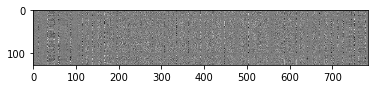

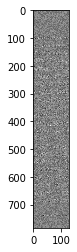

In [291]:
for i in model2.parameters():
  if len(i.shape)>1:
      plt.imshow(i.cpu().data,'gray')
      plt.show()

**Visualizing filter denoising autoencoder**

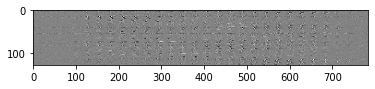

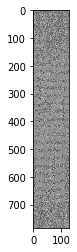

In [290]:
for i in model6.parameters():
  if len(i.shape)>1:
      plt.imshow(i.cpu().data,'gray')
      plt.show()

From above plots we can see that filters of denoising autoencoder have pattern white strips which indicate zero weights for dropping the noise effect from the image.


# 5. Manifold Learning

**Adding noise to 784 dimensions **

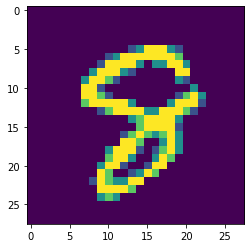

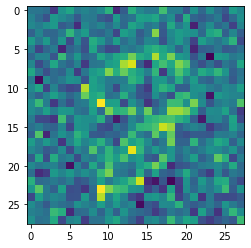

In [212]:
rand_no = np.random.randint(1,10000)
#enc = model0.encoder()
enc_noise = test_images[rand_no] + torch.Tensor(np.random.normal(0,0.5,784))
plt.imshow(test_images[rand_no].view(28,28))
plt.show()
plt.imshow(enc_noise.view(28,28))

**Adding noise to encoded representation**

In [0]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 64),
            nn.ReLU(True),nn.Linear(64, 8),
            nn.ReLU(True))
        self.decoder = nn.Sequential(
            nn.Linear(8, 64),
            nn.ReLU(True),nn.Linear(64, 784),
            nn.ReLU(True))
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded,decoded


In [0]:
model9 = autoencoder().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model9.parameters(), lr= 0.001)

In [0]:
beta = 0.05
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0), -1)
        img = Variable(img)
        #img1 = img  + torch.Tensor(np.random.normal(0,0.9,(img.size(0),784))).cuda()
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        enc_output,dec_output = model9(img)
        loss = criterion(dec_output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
           # images1 = images + torch.Tensor(np.random.normal(0,0.9,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model9(images)
            loss_train = criterion(dec_outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), -1)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
           # images1 = images + torch.Tensor(np.random.normal(0,0.9,(images.size(0),784))).cuda()
            enc_outputs,dec_outputs = model9(images)
            loss_val = criterion(dec_outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0406	 val_loss:0.0406
epoch [2/20], train_loss:0.0382	 val_loss:0.0383
epoch [3/20], train_loss:0.0368	 val_loss:0.0368
epoch [4/20], train_loss:0.0361	 val_loss:0.0362
epoch [5/20], train_loss:0.0357	 val_loss:0.0358
epoch [6/20], train_loss:0.0353	 val_loss:0.0354
epoch [7/20], train_loss:0.0350	 val_loss:0.0352
epoch [8/20], train_loss:0.0345	 val_loss:0.0347
epoch [9/20], train_loss:0.0343	 val_loss:0.0344
epoch [10/20], train_loss:0.0336	 val_loss:0.0338
epoch [11/20], train_loss:0.0332	 val_loss:0.0334
epoch [12/20], train_loss:0.0328	 val_loss:0.0330
epoch [13/20], train_loss:0.0328	 val_loss:0.0331
epoch [14/20], train_loss:0.0327	 val_loss:0.0329
epoch [15/20], train_loss:0.0325	 val_loss:0.0328
epoch [16/20], train_loss:0.0325	 val_loss:0.0328
epoch [17/20], train_loss:0.0324	 val_loss:0.0327
epoch [18/20], train_loss:0.0324	 val_loss:0.0326
epoch [19/20], train_loss:0.0323	 val_loss:0.0325
epoch [20/20], train_loss:0.0323	 val_loss:0.0326


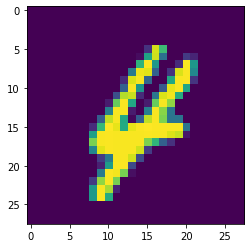

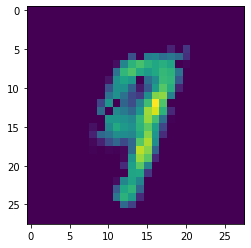

In [0]:
rand_no = np.random.randint(1,10000)
enc = model9.encoder(test_images[rand_no].cuda())
enc_noise = enc + torch.Tensor(np.random.normal(0,2,8)).cuda()
recon = model9.decoder(enc_noise)
plt.imshow(test_images[rand_no].view(28,28))
plt.show()
plt.imshow(recon.cpu().data.view(28,28))

When we move in different directions in 784 dimensions or add noise in this dimension, the output is not a digit, However when we move in different directions in encoded representation or learned manifold we land in the digit subspace itself so output will be digit only.




# 6. Convolutional Autoencoders

**i) Unpooling**

In [0]:
class convolutional_autoencoder_1(nn.Module):
    def __init__(self):
        super(convolutional_autoencoder_1, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.maxpool1 =  nn.MaxPool2d(2, return_indices = True)
        self.conv2 = nn.Conv2d(8,16,3)
        self.maxpool2 = nn.MaxPool2d(2,return_indices= True)
        self.conv3 = nn.Conv2d(16,16,3)
        self.maxpool3 = nn.MaxPool2d(2,return_indices= True)

        self.unpool1 = nn.MaxUnpool2d(2)
        self.conv4 = nn.Conv2d(16,16,3,padding = 2)
        self.unpool2 = nn.MaxUnpool2d(2)
        self.conv5 = nn.Conv2d(16,8,3,padding = 2)
        self.unpool3 = nn.MaxUnpool2d(2)
        self.conv6 = nn.Conv2d(8,1,3,padding = 2)
    def encoder(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x,indices_1 = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x,indices_2 = self.maxpool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x,indices_3 = self.maxpool2(x)
        x = F.relu(x)
        return x,indices_1,indices_2,indices_3

    def decoder(self,x,indices_1,indices_2,indices_3):
        
        x = self.unpool1(x,indices_3,output_size = torch.Size([x.size(0),16,3,3]))
       # print(x.shape)
        x = self.conv4(x)
        
      #  print(x.shape,indices_2.shape)
        x = self.unpool2(x,indices_2,output_size = torch.Size([x.size(0),16,11,11]))
        x = F.relu(x)
        #print(x.shape)
        x = self.conv5(x)
        
        x = self.unpool3(x,indices_1)
        x = F.relu(x)
        x = self.conv6(x)
        x = F.relu(x)
        return x

    def forward(self, x):
        x,indices_1,indices_2,indices_3 = self.encoder(x)
        x = self.decoder(x,indices_1,indices_2,indices_3)
        return x


In [0]:
model10 = convolutional_autoencoder_1().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model10.parameters(), lr= 0.001)

In [263]:
num_epochs = 10
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0),1,28,28)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        output = model10(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0),1, 28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model10(images)
            loss_train = criterion(outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), 1,28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model10(images)
            loss_val = criterion(outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/10], train_loss:0.0103	 val_loss:0.0103
epoch [2/10], train_loss:0.0082	 val_loss:0.0082
epoch [3/10], train_loss:0.0076	 val_loss:0.0076
epoch [4/10], train_loss:0.0074	 val_loss:0.0074
epoch [5/10], train_loss:0.0072	 val_loss:0.0073
epoch [6/10], train_loss:0.0071	 val_loss:0.0071
epoch [7/10], train_loss:0.0069	 val_loss:0.0069
epoch [8/10], train_loss:0.0068	 val_loss:0.0068
epoch [9/10], train_loss:0.0066	 val_loss:0.0066
epoch [10/10], train_loss:0.0065	 val_loss:0.0065


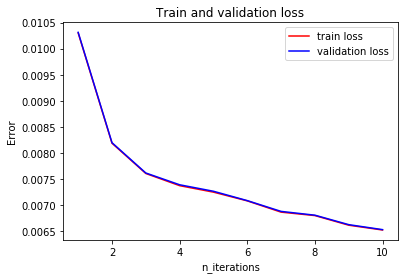

In [264]:
epoch = [i for i in range(1,len(run_train_loss)+1)]
plt.plot(epoch,run_train_loss,'-r')
plt.plot(epoch,run_val_loss,'-b')
plt.title('Train and validation loss')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('train loss','validation loss'))
plt.show()

In [265]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), 1,28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model10(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.006535502260396625


In [0]:
test_auto = model10(test_images.type(torch.FloatTensor).view(-1,1,28,28).cuda())

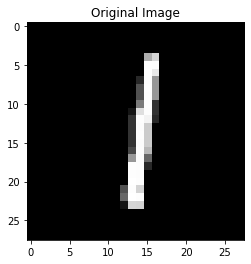

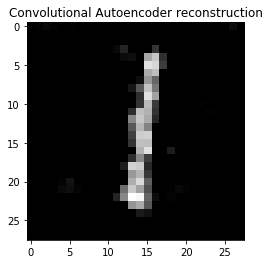

In [267]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28),'gray')
plt.title('Original Image')
plt.show()
plt.imshow(test_auto[rand_no].data.cpu().view(28,28),'gray')
plt.title('Convolutional Autoencoder reconstruction')
plt.show()

**Visualization Weights of decoder**

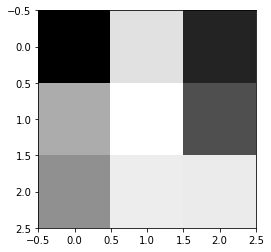

In [268]:
plt.imshow(model10.conv4.weight.data.cpu()[0,0,:,:],'gray')

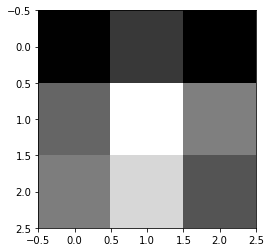

In [269]:
plt.imshow(model10.conv5.weight.data.cpu()[0,0,:,:],'gray')

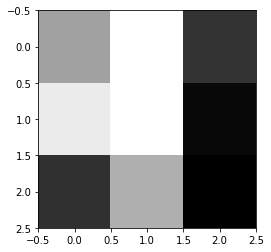

In [270]:
plt.imshow(model10.conv6.weight.data.cpu()[0,0,:,:],'gray')

**2. Unpooling + Deconvolution**

In [0]:
class convolutional_autoencoder_2(nn.Module):
    def __init__(self):
        super(convolutional_autoencoder_2, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.maxpool1 =  nn.MaxPool2d(2, return_indices = True)
        self.conv2 = nn.Conv2d(8,16,3)
        self.maxpool2 = nn.MaxPool2d(2,return_indices= True)
        self.conv3 = nn.Conv2d(16,16,3)
        self.maxpool3 = nn.MaxPool2d(2,return_indices= True)
        

        
        self.unpool1 = nn.MaxUnpool2d(2)
        self.de_conv1 = nn.ConvTranspose2d(16,16,3)
        self.unpool2 = nn.MaxUnpool2d(2)
        self.de_conv2 = nn.ConvTranspose2d(16,8,3)
        self.unpool3 = nn.MaxUnpool2d(2)
        self.de_conv3 = nn.ConvTranspose2d(8,1,3)
    def encoder(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x,indices_1 = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x,indices_2 = self.maxpool2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x,indices_3 = self.maxpool2(x)
        return x,indices_1,indices_2,indices_3

    def decoder(self,x,indices_1,indices_2,indices_3):
        #print(x.shape,indices_3.shape)
        x = self.unpool1(x,indices_3,output_size = [x.size(0),16,3,3])
        #print(x.shape)
        x = self.de_conv1(x)
        
       # print(x.shape,indices_2.shape)
        x = self.unpool2(x,indices_2,output_size = [x.size(0),16,11,11])
        x = F.relu(x)
       # print(x.shape,indices_1.shape)
        x = self.de_conv2(x)
        
       # print(x.shape,indices_1.shape)
        x = self.unpool3(x,indices_1)
        x = F.relu(x)
        x = self.de_conv3(x)
        x = F.relu(x)
        return x

    def forward(self, x):
        x,indices_1,indices_2,indices_3= self.encoder(x)
        x = self.decoder(x,indices_1,indices_2,indices_3)
        return x


In [0]:
model11 = convolutional_autoencoder_2().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model11.parameters(), lr= 0.001)

In [218]:
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0),1,28,28)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        output = model11(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0),1, 28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model11(images)
            loss_train = criterion(outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), 1,28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model11(images)
            loss_val = criterion(outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0135	 val_loss:0.0135
epoch [2/20], train_loss:0.0102	 val_loss:0.0102
epoch [3/20], train_loss:0.0092	 val_loss:0.0092
epoch [4/20], train_loss:0.0087	 val_loss:0.0087
epoch [5/20], train_loss:0.0081	 val_loss:0.0082
epoch [6/20], train_loss:0.0068	 val_loss:0.0068
epoch [7/20], train_loss:0.0066	 val_loss:0.0066
epoch [8/20], train_loss:0.0064	 val_loss:0.0064
epoch [9/20], train_loss:0.0063	 val_loss:0.0063
epoch [10/20], train_loss:0.0065	 val_loss:0.0065
epoch [11/20], train_loss:0.0064	 val_loss:0.0064
epoch [12/20], train_loss:0.0064	 val_loss:0.0064
epoch [13/20], train_loss:0.0063	 val_loss:0.0063
epoch [14/20], train_loss:0.0063	 val_loss:0.0063
epoch [15/20], train_loss:0.0063	 val_loss:0.0063
epoch [16/20], train_loss:0.0063	 val_loss:0.0063
epoch [17/20], train_loss:0.0064	 val_loss:0.0064
epoch [18/20], train_loss:0.0064	 val_loss:0.0064
epoch [19/20], train_loss:0.0065	 val_loss:0.0065
epoch [20/20], train_loss:0.0064	 val_loss:0.0064


In [219]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), 1,28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model11(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.006424464946790676


In [0]:
test_auto = model11(test_images.type(torch.FloatTensor).view(-1,1,28,28).cuda())

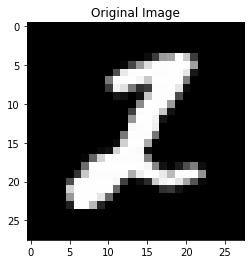

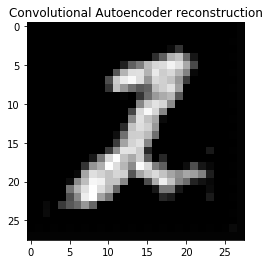

In [221]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28),'gray')
plt.title('Original Image')
plt.show()
plt.imshow(test_auto[rand_no].data.cpu().view(28,28),'gray')
plt.title('Convolutional Autoencoder reconstruction')
plt.show()

**Visualization Weights of decoder**

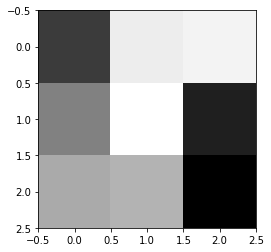

In [236]:
plt.imshow(model11.de_conv1.weight.data.cpu()[0,0,:,:],'gray')

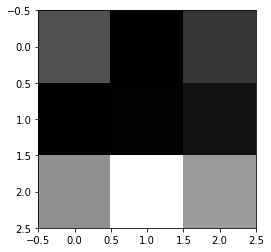

In [237]:
plt.imshow(model11.de_conv2.weight.data.cpu()[0,0,:,:],'gray')

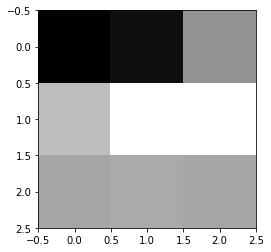

In [238]:
plt.imshow(model11.de_conv3.weight.data.cpu()[0,0,:,:],'gray')

**iii) Deconvolution**

In [0]:
class convolutional_autoencoder_3(nn.Module):
    def __init__(self):
        super(convolutional_autoencoder_3, self).__init__()
        
        self.conv1 = nn.Conv2d(1, 8, 3)
        self.maxpool1 =  nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(8,16,3)
        self.maxpool2 = nn.MaxPool2d(2)
        self.conv3 = nn.Conv2d(16,16,3)
        self.maxpool3 = nn.MaxPool2d(2)

        self.de_conv1 = nn.ConvTranspose2d(16,16,3,stride = 2)
        self.de_conv2 = nn.ConvTranspose2d(16,16,3)
        self.de_conv3 = nn.ConvTranspose2d(16,8,3,stride = 2)
        self.de_conv4 = nn.ConvTranspose2d(8,8,3)
        self.de_conv5 = nn.ConvTranspose2d(8,8,2,stride = 2)
        self.de_conv6 = nn.ConvTranspose2d(8,1,3)
    def encoder(self,x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.maxpool1(x)
        x = self.conv2(x)
        x = F.relu(x)
       # print(x.shape)
        x = self.maxpool2(x)
        x = self.conv3(x)
        x = F.relu(x)
       # print(x.shape)
        x = self.maxpool3(x)
        x = F.relu(x)
        return x

    def decoder(self,x):
        x = self.de_conv1(x)
        x = self.de_conv2(x)
        x = F.relu(x)
        x = self.de_conv3(x)
        x = F.relu(x)
        x = self.de_conv4(x)
        
        
        x = self.de_conv5(x)
        x = F.relu(x)
        x = self.de_conv6(x)
        
        return x

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [0]:
model12 = convolutional_autoencoder_3().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(
model12.parameters(), lr= 0.001)

In [127]:
num_epochs = 20
run_train_loss = []
run_val_loss = []
for epoch in range(num_epochs):
    for data in train_loader:
        img = data
        img = img.view(img.size(0),1,28,28)
        img = Variable(img)
        # ===================forward=====================
        img = img.type(torch.FloatTensor).cuda()
        output = model12(img)
        loss = criterion(output, img)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    with torch.no_grad():
        train_loss = 0
        total_train = 0
        for data in train_loader:
            images = data
            images = images.view(images.size(0),1, 28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model12(images)
            loss_train = criterion(outputs, images)
            train_loss += loss_train
            total_train += 1
          
    run_train_loss.append(train_loss/total_train)
    with torch.no_grad():
        val_loss = 0
        total_val = 0
        for data in val_loader:
            images = data
            images = images.view(images.size(0), 1,28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model12(images)
            loss_val = criterion(outputs, images)
            val_loss += loss_val
            total_val += 1
    run_val_loss.append(val_loss/total_val)
    
            
    # ===================log========================
    print('epoch [{}/{}], train_loss:{:.4f}\t val_loss:{:.4f}'
          .format(epoch + 1, num_epochs, train_loss/total_train,val_loss/total_val))

epoch [1/20], train_loss:0.0304	 val_loss:0.0305
epoch [2/20], train_loss:0.0251	 val_loss:0.0252
epoch [3/20], train_loss:0.0231	 val_loss:0.0231
epoch [4/20], train_loss:0.0219	 val_loss:0.0220
epoch [5/20], train_loss:0.0215	 val_loss:0.0216
epoch [6/20], train_loss:0.0211	 val_loss:0.0212
epoch [7/20], train_loss:0.0203	 val_loss:0.0204
epoch [8/20], train_loss:0.0201	 val_loss:0.0202
epoch [9/20], train_loss:0.0201	 val_loss:0.0203
epoch [10/20], train_loss:0.0197	 val_loss:0.0199
epoch [11/20], train_loss:0.0193	 val_loss:0.0195
epoch [12/20], train_loss:0.0192	 val_loss:0.0194
epoch [13/20], train_loss:0.0192	 val_loss:0.0193
epoch [14/20], train_loss:0.0190	 val_loss:0.0192
epoch [15/20], train_loss:0.0190	 val_loss:0.0192
epoch [16/20], train_loss:0.0186	 val_loss:0.0188
epoch [17/20], train_loss:0.0187	 val_loss:0.0189
epoch [18/20], train_loss:0.0189	 val_loss:0.0191
epoch [19/20], train_loss:0.0185	 val_loss:0.0187
epoch [20/20], train_loss:0.0181	 val_loss:0.0184


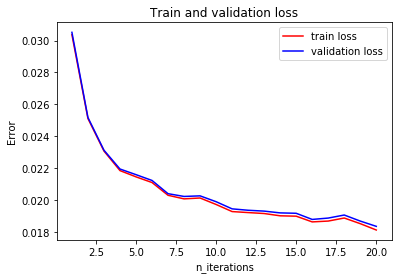

In [128]:
epoch = [i for i in range(1,len(run_train_loss)+1)]
plt.plot(epoch,run_train_loss,'-r')
plt.plot(epoch,run_val_loss,'-b')
plt.title('Train and validation loss')
plt.xlabel('n_iterations')
plt.ylabel('Error')
plt.gca().legend(('train loss','validation loss'))
plt.show()

In [129]:
with torch.no_grad():
        test_loss = 0
        total_test = 0
        for data in test_loader:
            images = data
            images = images.view(images.size(0), 1,28,28)
            images = Variable(images)
            images = images.type(torch.FloatTensor).cuda()
            outputs = model12(images)
            loss_test = criterion(outputs, images)
            loss_test = loss_test.item()
            test_loss += loss_test
            total_test += 1
Mse = test_loss/total_test
print('MSE:',Mse)

MSE: 0.017867046906642474


In [0]:
test_auto = model12(test_images.type(torch.FloatTensor).view(-1,1,28,28).cuda())

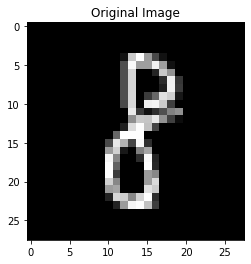

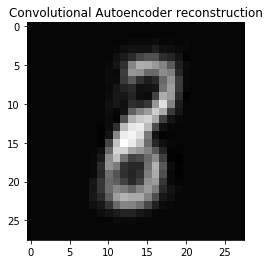

In [131]:
rand_no = np.random.randint(0,10000)
plt.imshow(test_images[rand_no].view(28,28),'gray')
plt.title('Original Image')
plt.show()
plt.imshow(test_auto[rand_no].data.cpu().view(28,28),'gray')
plt.title('Convolutional Autoencoder reconstruction')
plt.show()

**Visualization Weights of decoder**

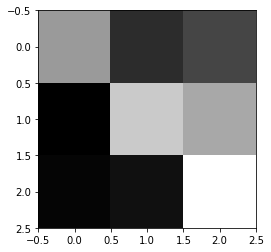

In [228]:
plt.imshow(model12.de_conv1.weight.data.cpu()[0,0,:,:],'gray')

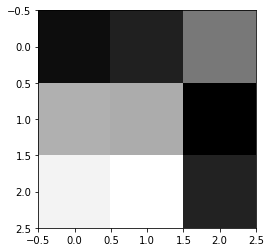

In [229]:
plt.imshow(model12.de_conv2.weight.data.cpu()[0,0,:,:],'gray')

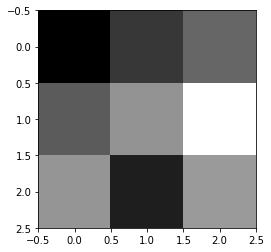

In [230]:
plt.imshow(model12.de_conv3.weight.data.cpu()[0,0,:,:],'gray')

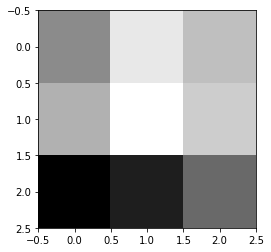

In [232]:
plt.imshow(model12.de_conv4.weight.data.cpu()[0,0,:,:],'gray')

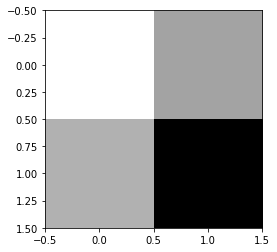

In [233]:
plt.imshow(model12.de_conv5.weight.data.cpu()[0,0,:,:],'gray')

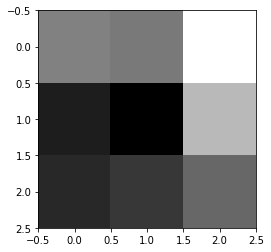

In [235]:
plt.imshow(model12.de_conv6.weight.data.cpu()[0,0,:,:],'gray')

Using only Unpooling, and unpooling + deconvolution we could get less MSE, using only deconvolution makes model more complex so requires more no. of epochs to reach the same MSE as obtained in the above case.